In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


# New Speedup Curves on ResNet-18 Batch Size 1024

In [62]:
subfix = '_workers_b1k'
num_worker = [2, 4, 8, 16 ,32]
stats = []
for w in num_worker:
    stat_dict = {}
    with open(str(w)+subfix, 'rb') as worker_file:
        for line in worker_file.readlines():
            line_string = line.rstrip('\n')
            #print(line_string)
            search_sth = re.match('Worker: (.*), Cur Step: (.*), Train Epoch: .* \[.*/.* \(.*%\)\], Train Loss: .*, Time Cost: (.*), FetchWeight: (.*), Forward: (.*), Backward: (.*)', line_string)
            if search_sth:
                worker_id, cur_step, time_cost = search_sth.group(1), int(search_sth.group(2)), float(search_sth.group(3))
                if cur_step not in stat_dict.keys():
                    stat_dict[cur_step] = [time_cost]
                else:
                    stat_dict[cur_step].append(time_cost)
        stats.append(stat_dict)

#processing results:
time_costs = []
ideal_time_costs = []
for i, dic in enumerate(stats):
    tmp_time_costs = []
    tmp_ideal_time_costs = []
    for k, v in dic.iteritems():
        tmp_time_costs.append(max(v))
        tmp_ideal_time_costs.append(min(v))
    time_costs.append(sum(tmp_time_costs))
    ideal_time_costs.append(sum(tmp_ideal_time_costs))
time_costs.insert(0, 2.1*time_costs[0])
ideal_time_costs.insert(0, 2.1*time_costs[1])
speed_ups = [time_costs[0]/i for i in time_costs]
ideal_speed_ups = [ideal_time_costs[0]/i for i in ideal_time_costs]
print(speed_ups)
print(ideal_speed_ups)

[1.0, 2.1000000000000001, 3.8152224265282846, 6.8451647580032651, 9.1929687329799918, 6.8121435168849507]
[1.0, 2.2365079600940012, 4.2687722057125619, 8.2544560425580258, 12.910453251559241, 12.451618945906779]


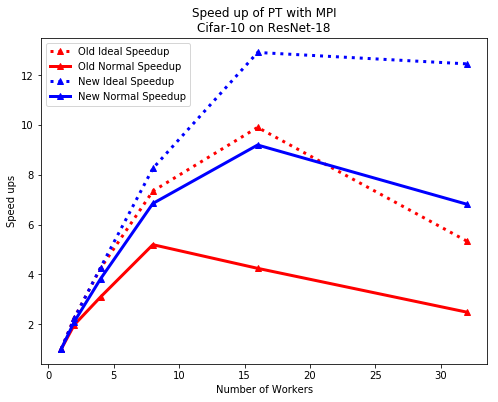

In [63]:
num_worker_interval = [1, 2, 4, 8, 16 ,32]
# batch size at 1024
normal_speedup_b1k = [1, 1.9737, 3.0871, 5.1896, 4.2394, 2.4774]
ideal_speedup_b1k = [1, 2.2547, 4.2394, 7.3414, 9.9013, 5.3274]

# batch size at 2048
normal_speedup_b2k = [1, 1.9937, 3.9572, 6.7889, 8.5549, 5.92]
ideal_speedup_b2k = [1, 2.0, 5.2857, 10.8029, 15.74468, 10.5714]

# batch size at 4096
normal_speedup_b4k = [1, 1.999, 3.799, 7.2922, 11.39739, 10.4150]
ideal_speedup_b4k = [1, 2.0, 4.0, 10.1493, 19.1011, 18.13333]

fig_2 = plt.figure()
plt.plot(num_worker_interval, ideal_speedup_b1k, ':^r',linewidth=3.0, label='Old Ideal Speedup')
plt.plot(num_worker_interval, normal_speedup_b1k, '-^r',linewidth=3.0, label='Old Normal Speedup')

plt.plot(num_worker_interval, ideal_speed_ups, ':^b',linewidth=3.0, label='New Ideal Speedup')
plt.plot(num_worker_interval, speed_ups, '-^b',linewidth=3.0, label='New Normal Speedup')
#plt.plot(num_worker_interval, ideal_speedup_b2k, ':^g', label='Ideal Speedup Batch:2048')
#plt.plot(num_worker_interval, normal_speedup_b2k, '-^g', label='Normal Speedup Batch:2048')
#plt.plot(num_worker_interval, ideal_speedup_b4k, ':^b', label='Ideal Speedup Batch:4096')
#plt.plot(num_worker_interval, normal_speedup_b4k, '-^b', label='Normal Speedup Batch:4096')
plt.title("Speed up of PT with MPI\nCifar-10 on ResNet-18")
plt.xlabel("Number of Workers")
plt.ylabel("Speed ups")
plt.legend()
#plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=300)
plt.show()

# Time Cost Distribution for 32 Workers

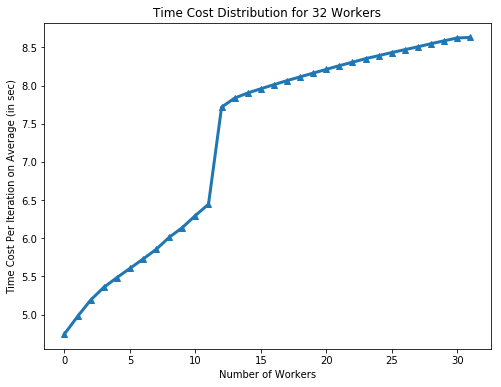

In [59]:
dic = stats[-1]
cdf = [0.0]*32
_step_counter=0
for k, v in dic.iteritems():
    _step_counter+=1
    for i, t in enumerate(v):
        cdf[i]+= t
cdf_plot = [i/float(_step_counter) for i in cdf]
fig = plt.figure()
plt.plot([i for i in range(32)], cdf_plot, '-^', linewidth=3.0)
plt.ylabel("Time Cost Per Iteration on Average (in sec)")
plt.xlabel('Number of Workers')
plt.title("Time Cost Distribution for 32 Workers")
plt.show()

# Time Cost Distribution for 16 Workers

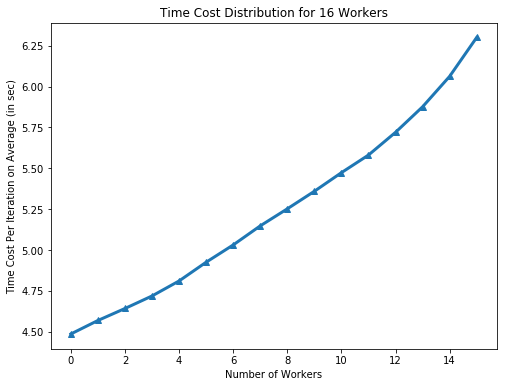

In [61]:
dic = stats[-2]
cdf = [0.0]*16
_step_counter=0
for k, v in dic.iteritems():
    _step_counter+=1
    for i, t in enumerate(v):
        cdf[i]+= t
cdf_plot = [i/float(_step_counter) for i in cdf]
fig = plt.figure()
plt.plot([i for i in range(16)], cdf_plot, '-^', linewidth=3.0)
plt.ylabel("Time Cost Per Iteration on Average (in sec)")
plt.xlabel('Number of Workers')
plt.title("Time Cost Distribution for 16 Workers")
plt.show()